In [1]:
import pandas as pd
import numpy as np
import imageio

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

## 1. Inspect images

In [3]:
import random,os

In [4]:
#Retrieve the list of uninfected and infected scan file names.
norm_path = "./chest_xray/train/NORMAL/"
infected_path = "./chest_xray/train/PNEUMONIA/"

norm_scans = os.listdir(norm_path)
infected_scans = os.listdir(infected_path)

In [5]:
#Check the number of uninfected and infected images
print("No. of uninfected scans: ",len(norm_scans))
print("No. of infected scans: ", len(infected_scans))

No. of uninfected scans:  1342
No. of infected scans:  3876


In [6]:
random.seed(99)
norm_sample = random.sample(norm_scans,6)
random.seed(99)
infected_sample = random.sample(infected_scans,6)

In [7]:
def show_images(filepath,filename,n_rows,n_cols):
    '''
    This function prints out multiple images.
    IN: path to image folder, list of image names, number of of rows, number of columns
    '''
    #Create a set of subplots
    fig, ax = plt.subplots(n_rows,n_cols,figsize=(5*n_cols,5*n_rows))
    
    #Read in and plot the images
    for index in range(len(filename)):
        #Read in the image
        image = imageio.imread(filepath+filename[index])
        #Plot the image, filling each row from left to right
        ax[index//n_cols][index%n_cols].imshow(image,cmap='gray') 

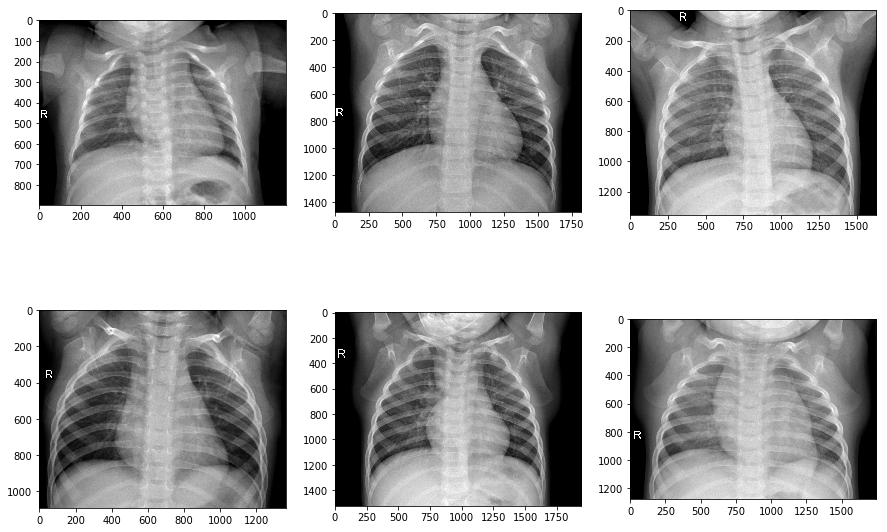

In [8]:
#View the uninfecetd scans
show_images(norm_path,norm_sample,2,3)

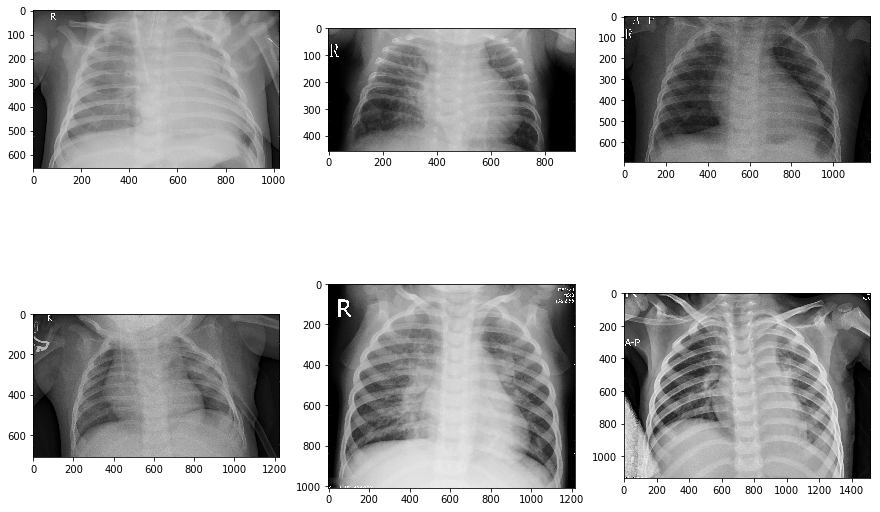

In [9]:
#View the infecetd scans
show_images(infected_path,infected_sample,2,3)

<div class="alert alert-block alert-warning">
    Visually, both infected and uninfected scans look the same to me.
</div>

## 2. Prepare Images

In [10]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [11]:
#Create data generators for train and test set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10,)

test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
#Create the train,validation and test sets
TARGET_SIZE = (128,128)
BATCH_SIZE = 10
EPOCHS = 50

train_set = train_datagen.flow_from_directory("./chest_xray/train/",
                                             target_size=TARGET_SIZE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='binary',subset='training')

#Original validation set has only 16 images, hence the use of the validation split from the training set to increase the validation set size
validation_set = train_datagen.flow_from_directory("./chest_xray/train/",
                                                  target_size=TARGET_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='binary',subset='validation')

test_set = test_datagen.flow_from_directory("./chest_xray/test/",
                                             target_size=TARGET_SIZE,
                                             batch_size=1,
                                             class_mode='binary',
                                                shuffle=False)

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 3. Modelling

In [13]:
from keras.models import Sequential,Model
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dropout,Activation,Dense,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from keras.applications import ResNet50

In [14]:
#Load in the ResNet50 model (without final layer or weights)
base_model = ResNet50(weights=None, include_top = False, input_shape=(128,128,3))

C:\MK\Anaconda3\envs\gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [15]:
#Add our own layers
= base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128,activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [16]:
#Build the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [18]:
#Set an earlystop if model stops improving
earlystop = EarlyStopping(monitor='val_acc',patience=5)
#Reduce learning rate if there's no progress
reduce_lr = ReduceLROnPlateau(monitor='loss',factor=0.1,patience=2,cooldown=2,min_lr=0.00001,verbose=1)
#Save the model periodically
savepoint= ModelCheckpoint('./resnet50_savepoint.hf5',monitor='val_loss',save_best_only=True,verbose=1)

In [19]:
#Train and validate the model
model_training = model.fit_generator(train_set,
                                     steps_per_epoch=train_set.samples/BATCH_SIZE,
                                     validation_data=validation_set,
                                     validation_steps=validation_set.samples/BATCH_SIZE,
                                     verbose=1,
                                     epochs=EPOCHS,callbacks=[earlystop,reduce_lr,savepoint])

Epoch 1/50
470/469 [==============================] - 229s 486ms/step - loss: 0.3434 - acc: 0.8781 - val_loss: 8.3800 - val_acc: 0.2860

Epoch 00001: val_loss improved from inf to 8.38001, saving model to ./resnet50_savepoint.hf5
Epoch 2/50
470/469 [==============================] - 176s 374ms/step - loss: 0.2146 - acc: 0.9166 - val_loss: 0.7217 - val_acc: 0.7639

Epoch 00002: val_loss improved from 8.38001 to 0.72173, saving model to ./resnet50_savepoint.hf5
Epoch 3/50
470/469 [==============================] - 148s 315ms/step - loss: 0.1689 - acc: 0.9349 - val_loss: 6.5464 - val_acc: 0.2841

Epoch 00003: val_loss did not improve from 0.72173
Epoch 4/50
470/469 [==============================] - 148s 315ms/step - loss: 0.1448 - acc: 0.9460 - val_loss: 0.2591 - val_acc: 0.8848

Epoch 00004: val_loss improved from 0.72173 to 0.25905, saving model to ./resnet50_savepoint.hf5
Epoch 5/50
470/469 [==============================] - 148s 315ms/step - loss: 0.1444 - acc: 0.9451 - val_loss: 0.2

Text(0, 0.5, 'Accuacy')

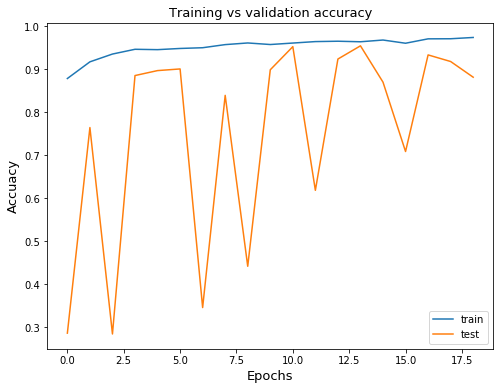

In [57]:
#Plot the training vs validation accuracy
plt.figure(figsize=(8,6))
plt.plot(model_training.history['acc'], label = 'train')
plt.plot(model_training.history['val_acc'], label = 'test')
plt.legend()

plt.title('Training vs validation accuracy',fontsize=13)
plt.xlabel('Epochs',fontsize=13)
plt.ylabel('Accuacy',fontsize=13)

Text(0, 0.5, 'Loss')

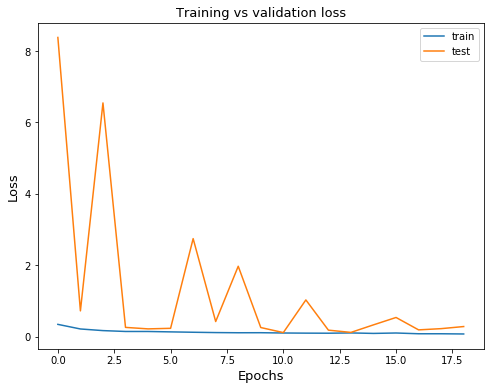

In [60]:
#Plot the training vs validation loss
plt.figure(figsize=(8,6))
plt.plot(model_training.history['loss'], label = 'train')
plt.plot(model_training.history['val_loss'], label = 'test')
plt.legend()

plt.title('Training vs validation loss',fontsize=13)
plt.xlabel('Epochs',fontsize=13)
plt.ylabel('Loss',fontsize=13)

In [41]:
from keras.models import load_model 

#Load the last saved model
saved_model = load_model('./resnet50_savepoint.hf5')

In [42]:
test_set.reset()
prediction = saved_model.predict_generator(test_set,steps=test_set.samples)

In [43]:
train_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [45]:
pred_classes = [1 if prob > 0.5 else 0 for prob in prediction]

In [47]:
#Store the filenames and predicted classes in a DataFrame
results_df = pd.DataFrame({'filename':test_set.filenames,'predicted':pred_classes})

In [48]:
#Add the actual classes to the DataFrame
results_df['Actual']=[0 if 'NORMAL' in name else 1 for name in results_df['filename']]

In [49]:
#Take a look at the DataFrame
results_df.head()

,filename,predicted,Actual
0,NORMAL\IM-0001-0001.jpeg,0,0
1,NORMAL\IM-0003-0001.jpeg,1,0
2,NORMAL\IM-0005-0001.jpeg,0,0
3,NORMAL\IM-0006-0001.jpeg,0,0
4,NORMAL\IM-0007-0001.jpeg,0,0


In [61]:
#Create the confusion matrix
con_matrix = pd.DataFrame(data=confusion_matrix(results_df['Actual'],results_df['predicted']),
                 columns=['Predicted normal','Predicted Pneumonia'],
                 index=['Actual Normal','Actual Pneumonia'])

In [62]:
#Check the confusion matrix
con_matrix

,Predicted normal,Predicted Pneumonia
Actual Normal,113,121
Actual Pneumonia,1,389


In [52]:
from sklearn.metrics import roc_auc_score

In [53]:
roc_auc_score(results_df['Actual'],pred_classes)

0.7401709401709402

<div class='alert alert-block alert-warning'>
    While false positives are usually regard as preferred opposed to false negatives in medical cases, the number of false positives are even higher than true negatives, which is rather alarming. One also has to consider what is the actual cost/fallout of a true negative (follow-up diagnosis, time and monetary cost, worry of patients).
</div>